In [1]:
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipkinc, ellipeinc, ellipk
import cmath

In [2]:
def calcQ(P: float,bh_mass: float, tol=1e-3) ->float:
    Q=np.sqrt((P - 2.*bh_mass)*(P + 6.*bh_mass))
    return Q

def bfromP(P: float,bh_mass: float, tol: float=1e-5) ->float:
    b = np.sqrt(P**3/(P - 2.*bh_mass))
    return b

def zetainf(P: float,bh_mass: float, tol=1e-6) ->float:
    Q = calcQ(P,bh_mass)
    arg =(Q-P+2.*bh_mass)/(Q-P + 6.*bh_mass)
    z_inf = np.arcsin(np.sqrt(arg))
    return z_inf

def k(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k = np.sqrt((Q-P+6*bh_mass)/(2*Q))
    return k

def k2(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k2 = (Q-P+6*bh_mass)/(2*Q)
    return k2

def cosgamma(_a: float, incl: float, tol=1e-5) -> float:
    if abs(incl) <tol:
        return 0
    return np.cos(_a)/np.sqrt(np.cos(_a)**2+1/(np.tan(incl)**2))

def eq13(P: float, ir_radius: float,ir_angle: float, bh_mass: float,incl: float, n: int=0, tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=g/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)

def midpoint_method(func,args:Dict, __x,__y,__ind):
    new_x = __x
    new_y = __y
    x_ = [new_x[__ind],new_x[__ind+1]]
    inbetween_x = np.mean(x_)
    new_x.insert(__ind+1,inbetween_x)
    
    y_ = [new_y[__ind],new_y[__ind+1]]
    inbetween_solution = func(P=inbetween_x, **args)
    new_y.insert(__ind+1,inbetween_solution)
    y_.insert(1, inbetween_solution)
    ind_of_sign_change_ =np.where(np.diff(np.sign(y_)))[0]
    new_ind=__ind + ind_of_sign_change_[0]
    return new_x, new_y, new_ind

def improve_solutions_midpoint(func, args, x, y, index_of_sign_change, iterations) -> float:
    index_of_sign_change_ = index_of_sign_change
    new_x =x
    new_y =y
    new_ind = index_of_sign_change_
    for iteration in range(iterations):
        new_x, new_y, new_ind = midpoint_method(func=func, args=args, __x=new_x, __y=new_y, __ind = new_ind)
    updated_P = new_x[new_ind]
    return updated_P

def calcP(_r, incl, _alpha, bh_mass, midpoint_iterations =100, plot_inbetween=False, n=0, min_P=1., initial_guesses=20) -> float:
    def get_plot(X,Y,solution, radius=_r):
        fig=plt.figure()
        plt.title("eq13(P)\nr={}, a={}".format(radius, round(_alpha,5)))
        plt.xlabel('P')
        plt.ylabel('Eq13(P)')
        plt.axhline(0,color='black')
        plt.plot(X,Y)
        plt.scatter(solution, 0, color='red')
        return plt
    periastron_range =list(np.linspace(min_P, 2.*_r, initial_guesses))
    y_ = [eq13(P_value, _r,_alpha, bh_mass, incl, n) for P_value in periastron_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    periastron_solution = periastron_range[ind[0]] if len(ind) else None
    if(periastron_solution is not None) and (not np.isnan(periastron_solution)):
        args_eq13 ={"ir_radius":_r, "ir_angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n}
        periastron_solution = \
        improve_solutions_midpoint(func=eq13, args=args_eq13, x=periastron_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    if plot_inbetween:
        get_plot(periastron_range, y_, periastron_solution).show
    return periastron_solution

def ellipse(r,a,incl):
    g=np.arccos(cosgamma(a,incl))
    b_=r*np.sin(g)
    return b_

def calcb(_r, incl, _alpha, bh_mass, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses) -> float:
    periastron_solution = calcP(_r,incl,_alpha,bh_mass, midpoint_iterations, plot_inbetween,n,min_P,initial_guesses)
    if periastron_solution is None or periastron_solution <=2.*bh_mass:
        return ellipse(_r, _alpha,incl)
    elif periastron_solution >2.*bh_mass:
        b=bfromP(periastron_solution, bh_mass)
        return b
    else:
        raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")

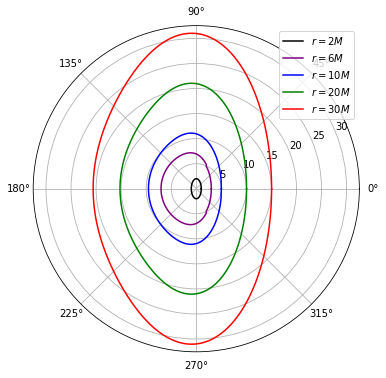

In [3]:
alphas = np.linspace(0, 2*np.pi, 1000)
isoradials_2_30 = np.empty(1000)
isoradials_6_30 = np.empty(1000)
isoradials_10_30 = np.empty(1000)
isoradials_20_30 = np.empty(1000)
isoradials_30_30 = np.empty(1000)

for i in range(0,1000):
    isoradials_2_30[i]= calcb(2, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_6_30[i]= calcb(6, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_10_30[i]= calcb(10, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_20_30[i]= calcb(20, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_30_30[i]= calcb(30, np.pi/3, alphas[i], 1, 100, False, 0, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_30, color= 'black', label="$r=2M$")
ax.plot(alphas, isoradials_6_30, color= 'purple', label="$r=6M$")
ax.plot(alphas, isoradials_10_30, color= 'blue', label="$r=10M$")
ax.plot(alphas, isoradials_20_30, color= 'green', label="$r=20M$")
ax.plot(alphas, isoradials_30_30, color= 'red', label="$r=30M$")
plt.legend()
plt.show()

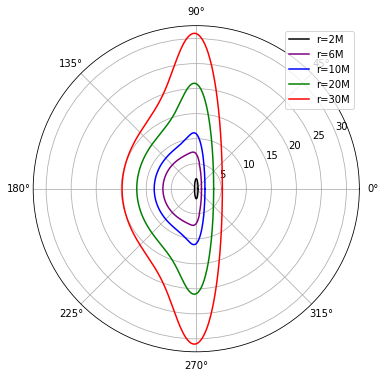

In [3]:
alphas = np.linspace(0, 2*np.pi, 1000)
isoradials_2_10 = np.empty(1000)
isoradials_6_10 = np.empty(1000)
isoradials_10_10 = np.empty(1000)
isoradials_20_10 = np.empty(1000)
isoradials_30_10 = np.empty(1000)

for i in range(0,1000):
    isoradials_2_10[i]= calcb(2, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_6_10[i]= calcb(6, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_10_10[i]= calcb(10, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_20_10[i]= calcb(20, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)
    isoradials_30_10[i]= calcb(30, 4*np.pi/9, alphas[i], 1, 100, False, 0, 3.001, 20)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_10, color= 'black', label="r=2M")
ax.plot(alphas, isoradials_6_10, color= 'purple', label="r=6M")
ax.plot(alphas, isoradials_10_10, color= 'blue', label="r=10M")
ax.plot(alphas, isoradials_20_10, color= 'green', label="r=20M")
ax.plot(alphas, isoradials_30_10, color= 'red', label="r=30M")
plt.legend()
plt.show()

In [3]:
#correction integrals
def coth(x):
    return 1/np.tanh(x)

def integralfunction(P, bh_mass, u):
    b = bfromP(P,bh_mass)
    term1 = -4*bh_mass*u*(2*bh_mass*u-coth(1/(2*bh_mass*u)))*(1+1/(2*bh_mass*b**2*u**3-b**2*u**2+1))
    term2 = 8*bh_mass**2*u**2*(4*bh_mass**2*u**2-coth(1/(4*bh_mass**2*u**2)))*(1-2*bh_mass*u/(2*bh_mass*b**2*u**3-b**2*u**2+1))/(1-2*bh_mass*u)
    return -1/(2*np.sqrt(2*bh_mass))*(term1+term2)/np.sqrt(u*3-u**2/(2*bh_mass)+1/(2*bh_mass*b**2))

def numericintegral(f,umin, umax, P, bh_mass, N):
    deltau = (umax - umin)/N
    u = umin
    I = deltau/6*(f(P, bh_mass,umin) - f(P, bh_mass,umax))
    for i in range(0, N):
        m = u + deltau/2
        u = u + deltau
        I = I + deltau/6*(2*f(P, bh_mass,u) + 4*f(P, bh_mass,m))
    return I

def correction(f, umin, umax, P, bh_mass, N):
    return numericintegral(f, umin, umax, P, bh_mass, N)

In [4]:
# correction eqns
def correctedeq13(f, P: float, ir_radius: float,ir_angle: float, bh_mass: float,umin: float,incl: float, n: int=0,  N:int=1000,tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    umax = 1/ir_radius
    I = correction(f, umin, umax, P, bh_mass, N)
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g+0.01*I-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=(g+0.01*I)/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)
                                                                                                                      
def calccorrectedP(f, _r, incl, _alpha, bh_mass,umin: float, midpoint_iterations =100, plot_inbetween=False, n=0, min_P=1., initial_guesses=20,  N:int=1000) -> float:
    def get_plot(X,Y,solution, radius=_r):
        fig=plt.figure()
        plt.title("correctedeq13(P)\nr={}, a={}".format(radius, round(_alpha,5)))
        plt.xlabel('P')
        plt.ylabel('CorrectedEq13(P)')
        plt.axhline(0,color='black')
        plt.plot(X,Y)
        plt.scatter(solution, 0, color='red')
        return plt
    periastron_range =list(np.linspace(min_P, 2.*_r, initial_guesses))
    y_ = [correctedeq13(f, P_value, _r,_alpha, bh_mass, umin, incl, n, N) for P_value in periastron_range]
    ind=np.where(np.diff(np.sign(y_)))[0]
    periastron_solution = periastron_range[ind[0]] if len(ind) else None
    if(periastron_solution is not None) and (not np.isnan(periastron_solution)):
        args_correctedeq13 ={"f": f,"ir_radius":_r, "ir_angle":_alpha, "bh_mass":bh_mass, "incl":incl, "n":n, "umin": umin, "N":N}
        periastron_solution = \
        improve_solutions_midpoint(func=correctedeq13, args=args_correctedeq13, x=periastron_range,y=y_, index_of_sign_change=ind[0], iterations = midpoint_iterations)
    if plot_inbetween:
        get_plot(periastron_range, y_, periastron_solution).show
    return periastron_solution
                                                                                                                    
def calccorrectedb(f, _r, incl, _alpha, bh_mass,umin, midpoint_iterations, plot_inbetween, n, min_P, initial_guesses, N) -> float:
    periastron_solution = calccorrectedP(f, _r,incl,_alpha,bh_mass,  umin, midpoint_iterations, plot_inbetween,n,min_P,initial_guesses,  N)
    if periastron_solution is None or periastron_solution <=2.*bh_mass:
        return ellipse(_r, _alpha,incl)
    elif periastron_solution >2.*bh_mass:
        b=bfromP(periastron_solution, bh_mass)
        return b
    else:
        raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")

/tmp/ipykernel_704/1228998783.py:8: RuntimeWarning: invalid value encountered in double_scalars
  term2 = 8*bh_mass**2*u**2*(4*bh_mass**2*u**2-coth(1/(4*bh_mass**2*u**2)))*(1-2*bh_mass*u/(2*bh_mass*b**2*u**3-b**2*u**2+1))/(1-2*bh_mass*u)


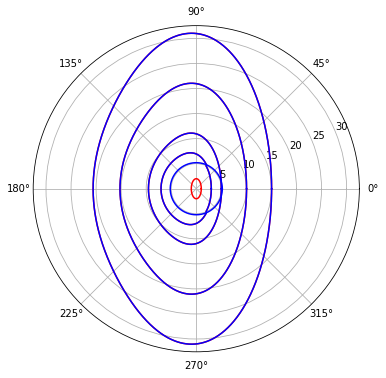

In [7]:
alphas = np.linspace(0, 2*np.pi, 1000)
correctedisoradials_2_30 = np.empty(1000)
correctedisoradials_6_30 = np.empty(1000)
correctedisoradials_10_30 = np.empty(1000)
correctedisoradials_20_30 = np.empty(1000)
correctedisoradials_30_30 = np.empty(1000)

for i in range(0,1000):
    correctedisoradials_2_30[i]= calccorrectedb(integralfunction, 2, np.pi/3, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)
    correctedisoradials_6_30[i]= calccorrectedb(integralfunction, 6, np.pi/3, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)
    correctedisoradials_10_30[i]= calccorrectedb(integralfunction, 10, np.pi/3, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)
    correctedisoradials_20_30[i]= calccorrectedb(integralfunction, 20, np.pi/3, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)
    correctedisoradials_30_30[i]= calccorrectedb(integralfunction, 30, np.pi/3, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_30, color= 'red')
ax.plot(alphas, isoradials_6_30, color= 'red')
ax.plot(alphas, isoradials_10_30, color= 'red')
ax.plot(alphas, isoradials_20_30, color= 'red')
ax.plot(alphas, isoradials_30_30, color= 'red')
ax.plot(alphas, correctedisoradials_2_30, color= 'blue')
ax.plot(alphas, correctedisoradials_6_30, color= 'blue')
ax.plot(alphas, correctedisoradials_10_30, color= 'blue')
ax.plot(alphas, correctedisoradials_20_30, color= 'blue')
ax.plot(alphas, correctedisoradials_30_30, color= 'blue')
plt.show()

In [ ]:
alphas = np.linspace(0, 2*np.pi, 1000)
correctedisoradials_2_10 = np.empty(1000)
correctedisoradials_6_10 = np.empty(1000)
correctedisoradials_10_10 = np.empty(1000)
correctedisoradials_20_10 = np.empty(1000)
correctedisoradials_30_10 = np.empty(1000)

for i in range(0,1000):
    correctedisoradials_2_10[i]= calccorrectedb(integralfunction, 2, 4*np.pi/9, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)
    correctedisoradials_6_10[i]= calccorrectedb(integralfunction, 6, 4*np.pi/9, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)
    correctedisoradials_10_10[i]= calccorrectedb(integralfunction, 10, 4*np.pi/9, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)
    correctedisoradials_20_10[i]= calccorrectedb(integralfunction, 20, 4*np.pi/9, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)
    correctedisoradials_30_10[i]= calccorrectedb(integralfunction, 30, 4*np.pi/9, alphas[i], 1, 0.001, 100, False, 0, 3.001, 20, 1000)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_10, color= 'red')
ax.plot(alphas, isoradials_6_10, color= 'red')
ax.plot(alphas, isoradials_10_10, color= 'red')
ax.plot(alphas, isoradials_20_10, color= 'red')
ax.plot(alphas, isoradials_30_10, color= 'red')
ax.plot(alphas, correctedisoradials_2_10, color= 'blue')
ax.plot(alphas, correctedisoradials_6_10, color= 'blue')
ax.plot(alphas, correctedisoradials_10_10, color= 'blue')
ax.plot(alphas, correctedisoradials_20_10, color= 'blue')
ax.plot(alphas, correctedisoradials_30_10, color= 'blue')
plt.show()

/tmp/ipykernel_221/1228998783.py:8: RuntimeWarning: invalid value encountered in double_scalars
  term2 = 8*bh_mass**2*u**2*(4*bh_mass**2*u**2-coth(1/(4*bh_mass**2*u**2)))*(1-2*bh_mass*u/(2*bh_mass*b**2*u**3-b**2*u**2+1))/(1-2*bh_mass*u)


In [8]:
print(1)

1
